<a href="https://colab.research.google.com/github/mariameche93/notebooks-colab/blob/main/02_Laboratorio/notebooks/02_Visualizacion_Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02 – Visualización de Datos con Wine

**Objetivo**  
Este cuaderno ofrece un análisis gráfico exhaustivo del dataset **Wine**, identificando distribuciones univariantes, relaciones bivariantes y patrones multivariantes. Se emplean tres niveles de visualización:

1. **Matplotlib**: gráficos básicos y personalizados  
2. **Seaborn**: visualizaciones estadísticas avanzadas  
3. **Plotly**: gráficos interactivos (bonus)  
4. **PCA**: reducción de dimensionalidad para interpretación

## Sección 1 – Configuración Inicial


En esta sección se importa y configura todo lo necesario para generar gráficos coherentes y reproducibles.


In [ ]:
# 1.1 Instalación de librerías
!pip install -q matplotlib seaborn plotly

# 1.2 Importaciones
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

# 1.3 Supresión de warnings
warnings.filterwarnings('ignore')

# 1.4 Estilo global
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12
})

print("✅ Librerías de visualización cargadas correctamente")

✅ Librerías de visualización cargadas correctamente


## Sección 2 – Carga y Preparación de Datos


In [ ]:
# 2.1 Preparar carpeta y tratar de leer Parquet
import os
import pandas as pd
from sklearn.datasets import load_wine

os.makedirs('data', exist_ok=True)

parquet_path = 'data/wine_raw.parquet'
if not os.path.exists(parquet_path):
    # Si el Parquet no existe, lo creamos aquí
    wine = load_wine(as_frame=True)
    df_temp = wine.frame.copy()
    # Añadir nombres de clase
    df_temp['target_name'] = df_temp['target']\
        .map(dict(enumerate(wine.target_names)))
    df_temp.to_parquet(parquet_path, index=False)
    print(f"🔄 Generado '{parquet_path}' desde scikit‑learn")

# 2.2 Cargar el DataFrame definitivo
df = pd.read_parquet(parquet_path)
print("✅ Dataset Wine cargado desde Parquet")
print("Dimensiones:", df.shape)
display(df.head())


🔄 Generado 'data/wine_raw.parquet' desde scikit‑learn
✅ Dataset Wine cargado desde Parquet
Dimensiones: (178, 15)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,target_name
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0


# Sección 3 – Gráficos Básicos con Matplotlib


## 3.1 Histogramas de variables seleccionadas


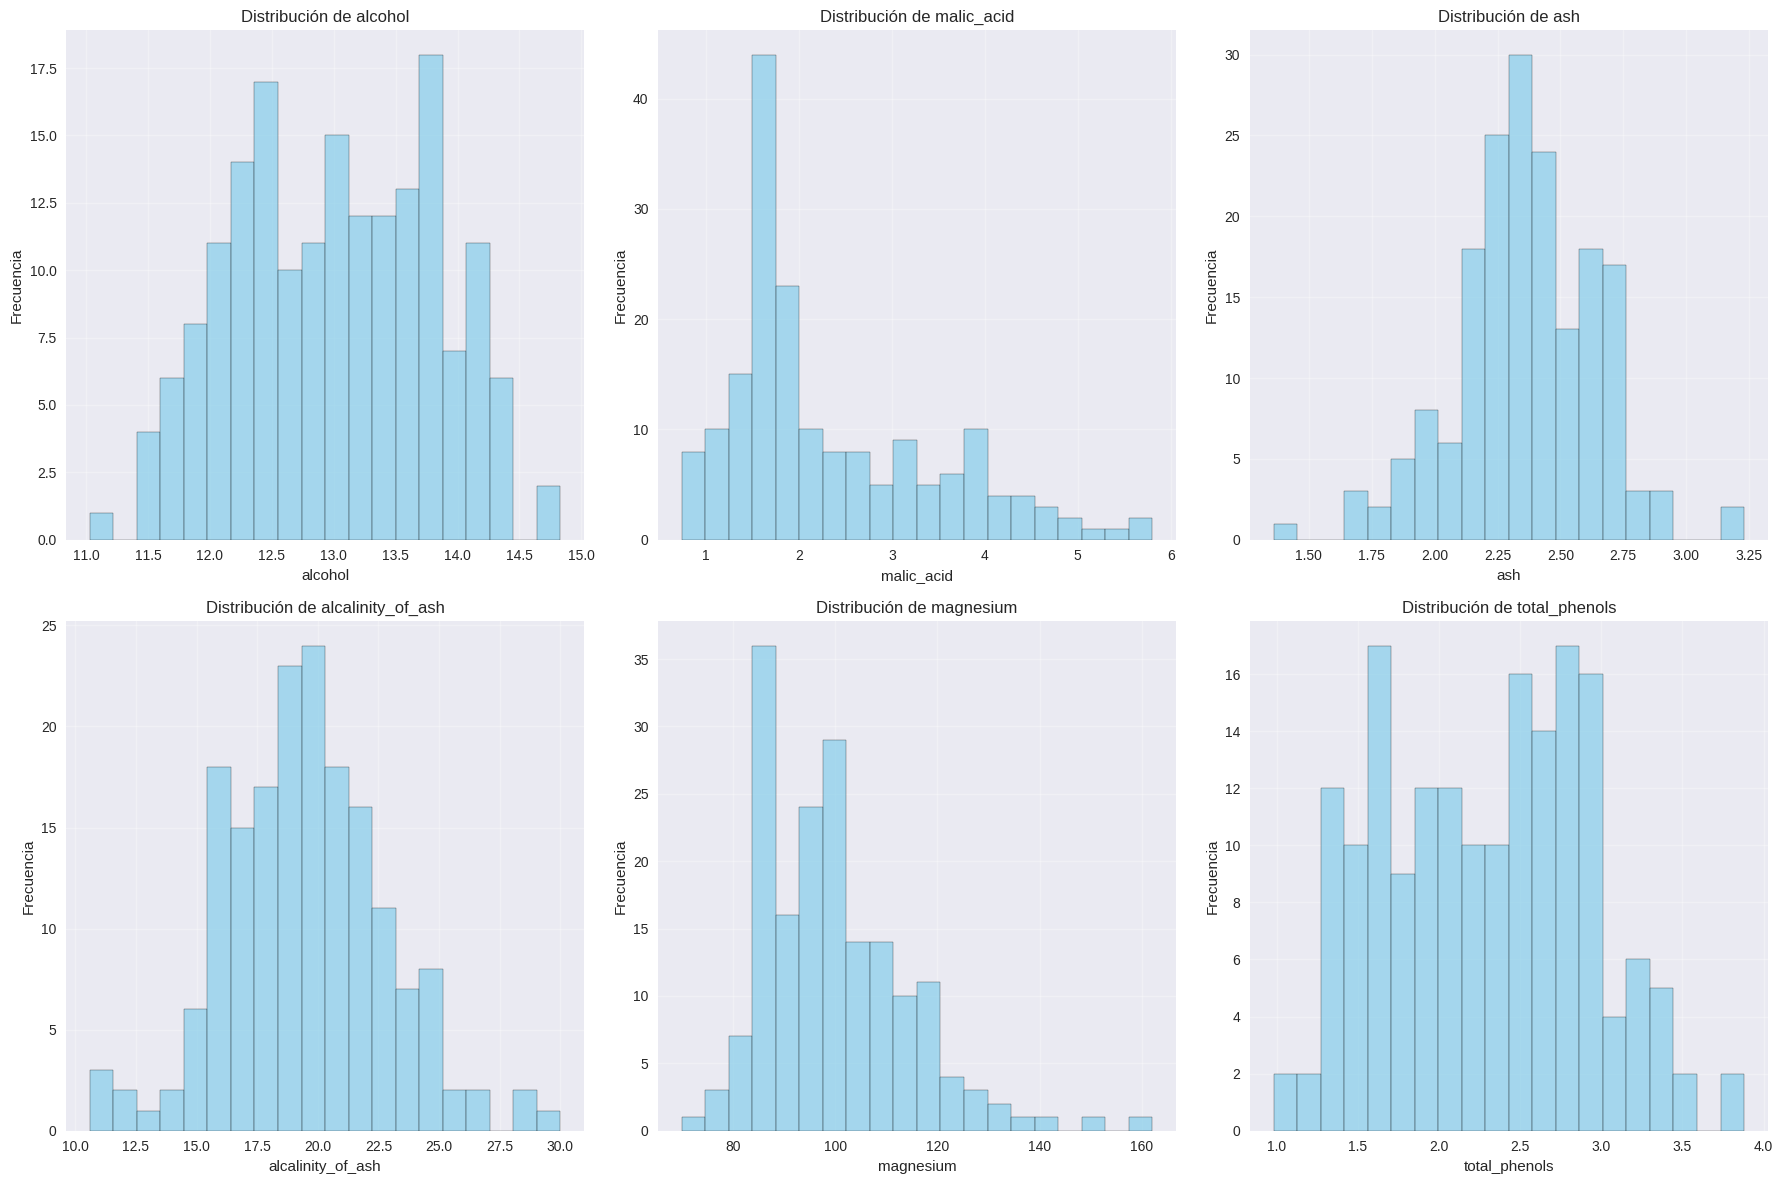

In [ ]:
features_importantes = [
    'alcohol', 'malic_acid', 'ash',
    'alcalinity_of_ash', 'magnesium', 'total_phenols'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for i, feat in enumerate(features_importantes):
    ax = axes[i//3, i%3]
    ax.hist(df[feat], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribución de {feat}')
    ax.set_xlabel(feat)
    ax.set_ylabel('Frecuencia')
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('02_Laboratorio/images/histograms.png')
plt.show()


- **alcohol**  
  - Distribución prácticamente simétrica con ligera leptocurtosis.  
  - Mayor densidad entre 12.0 % y 13.8 % v/v; colas poco pronunciadas.  
  - Apta para métodos paramétricos sin transformaciones adicionales.  

- **malic_acid**  
  - Marcada asimetría a la derecha.  
  - Pico prominente entre 1.0 – 2.0 g/L; valores extremos hasta 5.8 g/L.  
  - Requiere transformación logarítmica o Box‑Cox antes de aplicar modelos lineales.  

- **ash**  
  - Distribución unimodal cercana a la normal.  
  - Centro en ~ 2.3 g/L con varianza reducida.  
  - Sin evidencia de outliers severos; basta la estandarización z‑score.  

- **alcalinity_of_ash**  
  - Leve sesgo positivo.  
  - Densidad máxima entre 17 – 22 mg/L; observaciones aisladas por encima de 28 mg/L.  
  - Conviene revisar y, si procede, winsorizar los valores extremos.  

- **magnesium**  
  - Asimetría a la derecha pronunciada con cola larga.  
  - Pico principal entre 80 – 105 mg/L; extremos hasta 160 mg/L.  
  - Alta curtosis y sesgo justifican transformaciones de potencia y técnicas robustas.  

- **total_phenols**  
  - Distribución claramente bimodal.  
  - Dos modos en torno a 1.5 y 2.8 g/L sugieren subpoblaciones químicas.  
  - La bimodalidad puede mejorar la discriminación de clases; se sugiere explorar umbrales de segmentación.  



```
# Esto tiene formato de código
```

##3.2 Gráficos de dispersión bivariantes



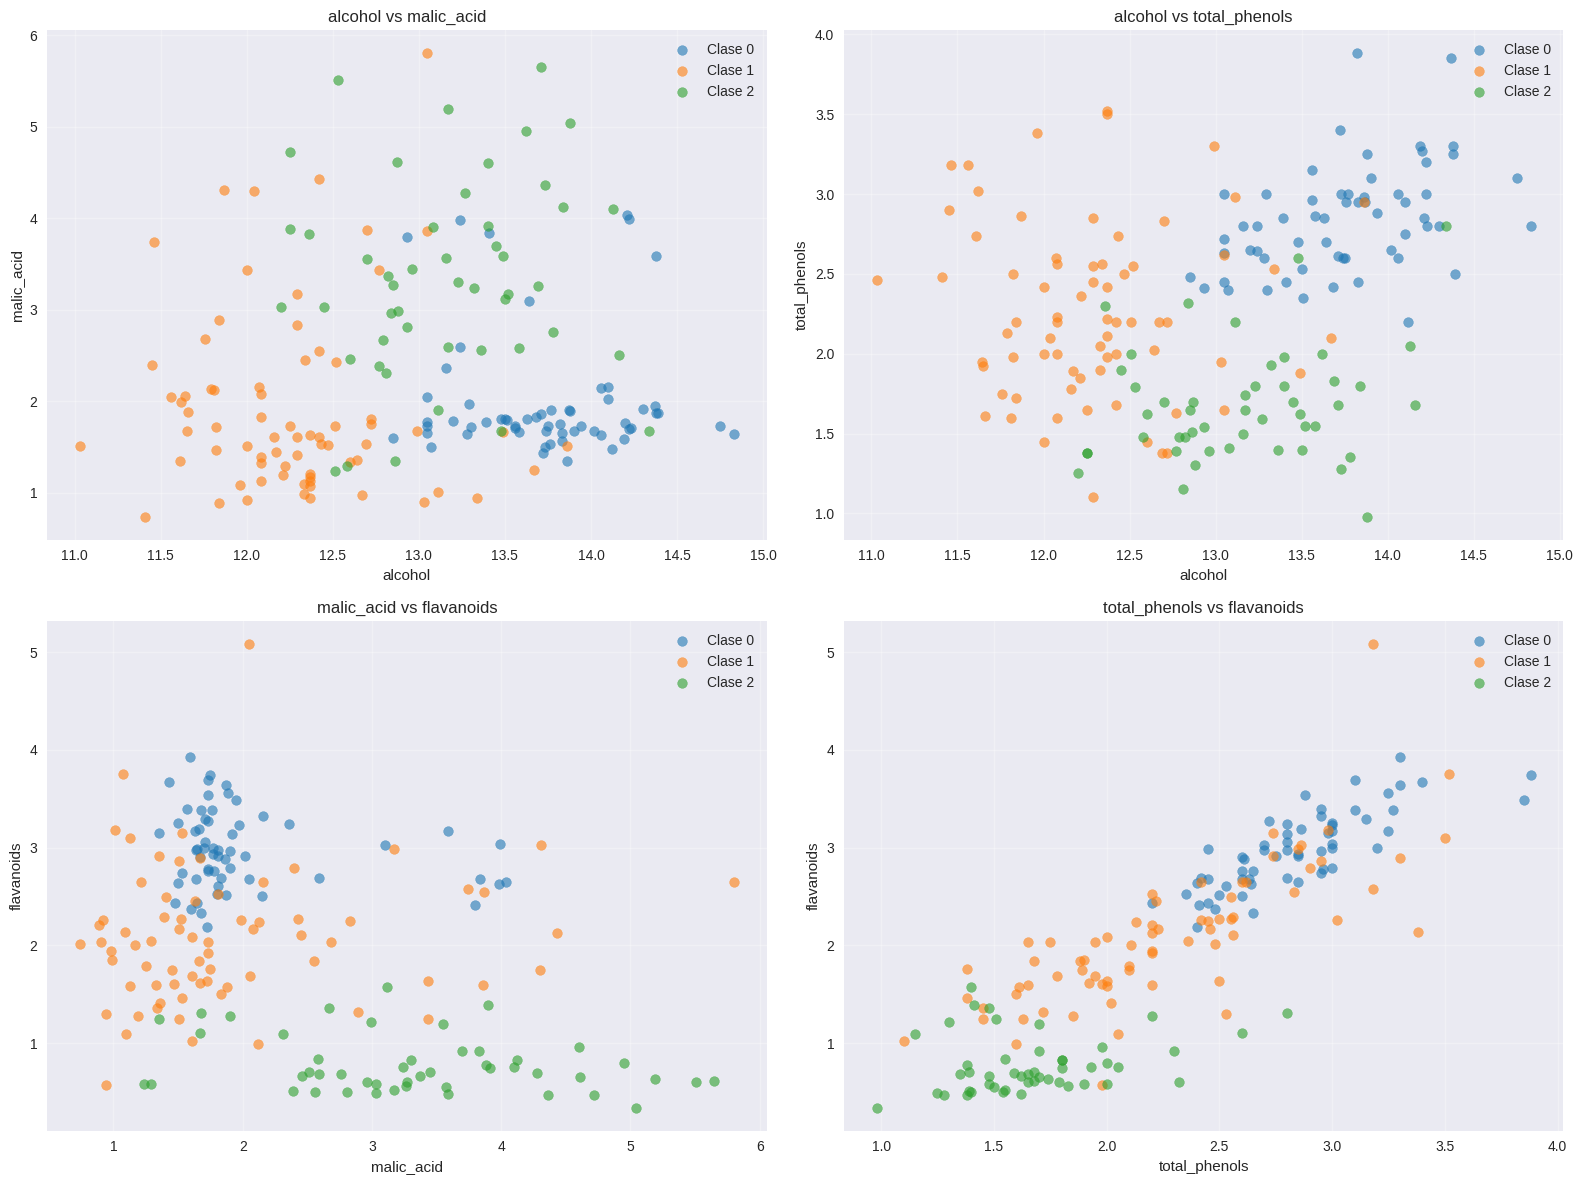

In [ ]:
pairs = [
    ('alcohol','malic_acid'),
    ('alcohol','total_phenols'),
    ('malic_acid','flavanoids'),
    ('total_phenols','flavanoids')
]
colors = ['tab:blue','tab:orange','tab:green']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for i, (x,y) in enumerate(pairs):
    ax = axes[i//2, i%2]
    for cls, c in enumerate(colors):
        sub = df[df['target']==cls]
        ax.scatter(sub[x], sub[y], c=c, label=f'Clase {cls}', alpha=0.6)
    ax.set_xlabel(x); ax.set_ylabel(y)
    ax.set_title(f'{x} vs {y}')
    ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('02_Laboratorio/images/scatter_pairs.png')
plt.show()


- **alcohol vs malic_acid**  
  - Tendencia inversa suave: a mayor graduación alcohólica, menor concentración de ácido málico.  
  - **Separación de clases**:  
    - `class_0` (azul) se ubica en el cuadrante de **alto alcohol / bajo malic_acid**.  
    - `class_1` (naranja) concentra **bajo alcohol / bajo malic_acid**.  
    - `class_2` (verde) presenta **alcohol medio / malic_acid elevado**, aislándose claramente.  
  - *Implicación*: la dupla discrimina con eficacia `class_2`; útil para un clasificador lineal simple.  

- **alcohol vs total_phenols**  
  - Correlación positiva moderada (patrón ascendente).  
  - **Separación de clases**:  
    - `class_0` muestra las mayores concentraciones de polifenoles y alcohol.  
    - `class_2` exhibe valores menores en ambos ejes.  
    - `class_1` se sitúa intermedio, con ligera superposición.  
  - *Implicación*: `total_phenols` potencia la discriminación entre `class_0` y `class_2`.  

- **malic_acid vs flavanoids**  
  - Correlación negativa pronunciada.  
  - **Separación de clases**:  
    - `class_0` combina **alto flavonoide / bajo ácido málico**.  
    - `class_2` se caracteriza por **bajo flavonoide / alto ácido málico**.  
    - `class_1` ocupa la zona media, con menor dispersión.  
  - *Implicación*: la relación inversa respalda la segmentación química; ideal para reglas de decisión basadas en umbrales.  

- **total_phenols vs flavanoids**  
  - Correlación positiva alta (pendiente casi lineal).  
  - **Separación de clases**:  
    - `class_0` domina el extremo **alto‑alto** (ambas variables elevadas).  
    - `class_2` agrupa valores **bajo‑bajo**.  
    - `class_1` se distribuye en la franja intermedia.  
  - *Implicación*: la relación lineal sugiere que una combinación ponderada de ambas variables reforzaría modelos lineales y LDA.  

> **Conclusión global**:  
> - Los pares seleccionados exhiben **patrones de correlación claros** (dos positivos, dos negativos) y proporcionan **fronteras de decisión** visualmente discernibles entre clases.  
> - Variables fenólicas (`total_phenols`, `flavanoids`) emergen como **factores discriminantes clave**, mientras que `malic_acid` y `alcohol` modulan la separación de `class_2` y `class_0`, respectivamente.  

##3.3 Boxplots comparativos



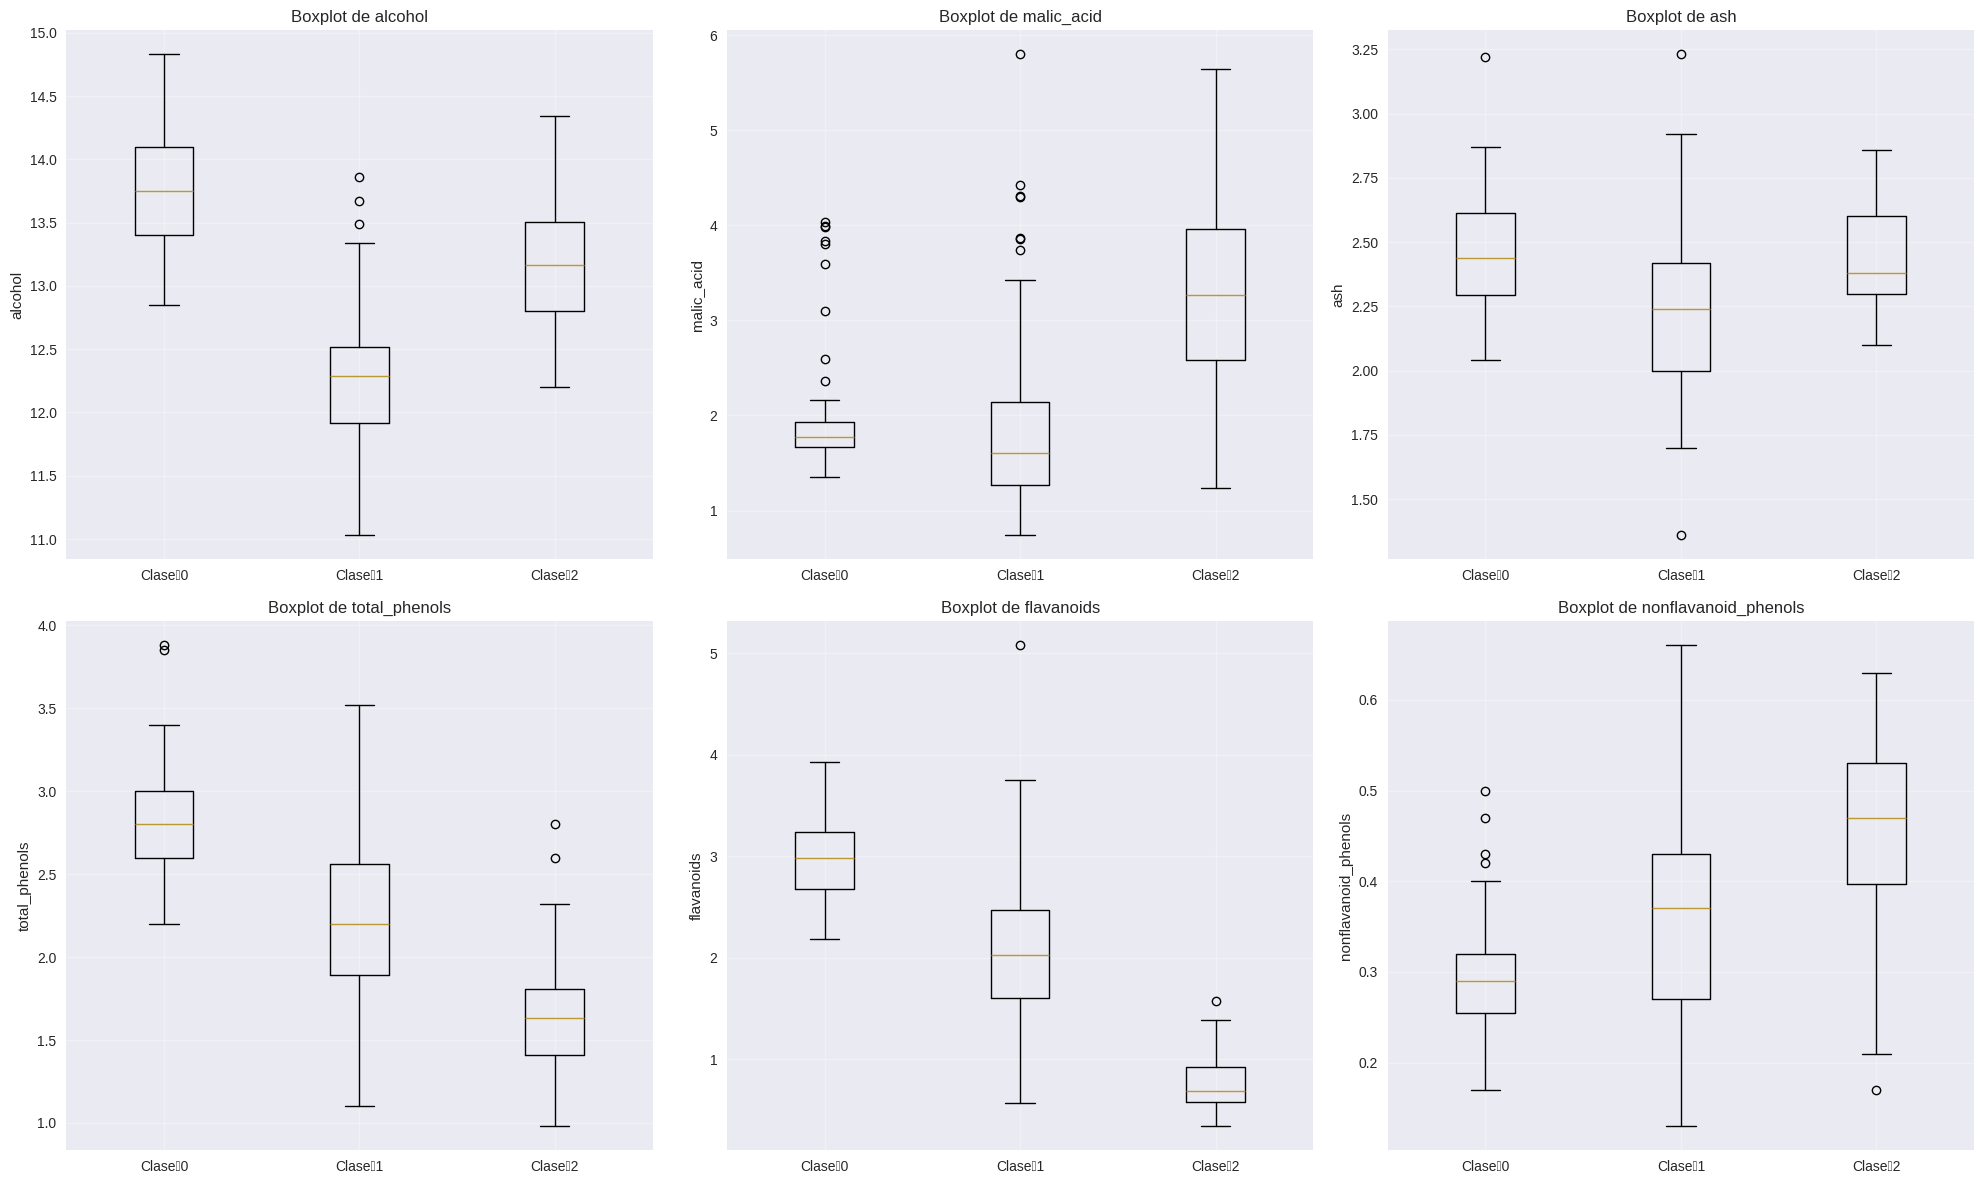

In [ ]:
features_box = [
    'alcohol','malic_acid','ash',
    'total_phenols','flavanoids','nonflavanoid_phenols'
]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
for i, feat in enumerate(features_box):
    ax = axes[i//3, i%3]
    data = [df[df['target']==cls][feat] for cls in [0,1,2]]
    ax.boxplot(data, labels=['Clase 0','Clase 1','Clase 2'])
    ax.set_title(f'Boxplot de {feat}')
    ax.set_ylabel(feat)
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('02_Laboratorio/images/boxplots.png')
plt.show()



- **alcohol**  
  - **Clase 0**: mediana ≈ 13.8 % v/v; rango intercuartil (RIQ) estrecho (13.5–14.1); varios outliers > 14.5 %.  
  - **Clase 1**: mediana ≈ 12.2 % v/v; mayor dispersión inferior (hasta ~ 11.0 %); mínimos outliers altos.  
  - **Clase 2**: mediana ≈ 13.2 % v/v; IQR intermedio (12.9–13.6); outliers aislados > 14.3 %.  
  - **Insight**: la graduación alcohólica discrimina claramente `class_1` (baja) frente a `class_0` (alta).  

- **malic_acid**  
  - **Clase 0**: mediana ≈ 1.8 g/L; rango compacto (1.6–2.1).  
  - **Clase 1**: mediana ≈ 1.6 g/L; RIQ algo más amplio; outliers hasta ~ 4.0 g/L.  
  - **Clase 2**: mediana ≈ 3.3 g/L; rango amplio (2.5–4.0); múltiples outliers > 5.5 g/L.  
  - **Insight**: variable decisiva para distinguir `class_2` (alto ácido málico) de las otras dos clases.  

- **ash**  
  - Medianas similares (~ 2.4 g/L) en las tres clases.  
  - **Clase 1** muestra la mayor dispersión inferior (mínimos hasta 1.4 g/L).  
  - Outliers ocasionales por encima de 3.0 g/L en `class_0` y `class_1`.  
  - **Insight**: poder discriminante limitado; puede requerir interacción con otras variables.  

- **total_phenols**  
  - **Clase 0**: mediana ≈ 2.8 g/L; rango 2.5–3.0; outliers altos (3.8–4.0 g/L).  
  - **Clase 1**: mediana ≈ 2.2 g/L; rango 1.9–2.6.  
  - **Clase 2**: mediana ≈ 1.6 g/L; rango 1.4–1.9; distribución más comprimida.  
  - **Insight**: presenta gradiente descendente claro (0 > 1 > 2); fuerte variable discriminante.  

- **flavanoids**  
  - **Clase 0**: mediana ≈ 2.7 g/L; IQR 2.4–3.0.  
  - **Clase 1**: mediana ≈ 2.0 g/L; rango 1.7–2.3; outliers altos ~ 5.1 g/L.  
  - **Clase 2**: mediana ≈ 0.8 g/L; rango 0.6–1.0.  
  - **Insight**: correlación directa con `total_phenols`; refuerza la separación de `class_0` y `class_2`.  

- **nonflavanoid_phenols**  
  - **Clase 0**: mediana ≈ 0.29 g/L; rango estrecho (0.27–0.32).  
  - **Clase 1**: mediana ≈ 0.33 g/L; rango 0.29–0.40; outliers hasta 0.63 g/L.  
  - **Clase 2**: mediana ≈ 0.45 g/L; rango 0.35–0.55.  
  - **Insight**: exhibe gradiente inverso (0 < 1 < 2) respecto a `flavanoids`; útil en combinación para reglas de decisión.  

---

**Conclusiones operativas**  
- Las variables fenólicas (`total_phenols`, `flavanoids`, `nonflavanoid_phenols`) y los ácidos (`malic_acid`) ofrecen **máxima capacidad de discriminación** entre clases.  
- `alcohol` proporciona un eje adicional, especialmente para aislar `class_1`.  
- `ash` aporta información marginal, pero podría mejorar el rendimiento en modelos multivariados complejos.  
- Se observaron **outliers** en `malic_acid` y `total_phenols`; considerar winsorización o métodos robustos según el algoritmo elegido.  


# Sección 4 – Visualizaciones Estadísticas con Seaborn


## 4.1 Heatmap de correlaciones



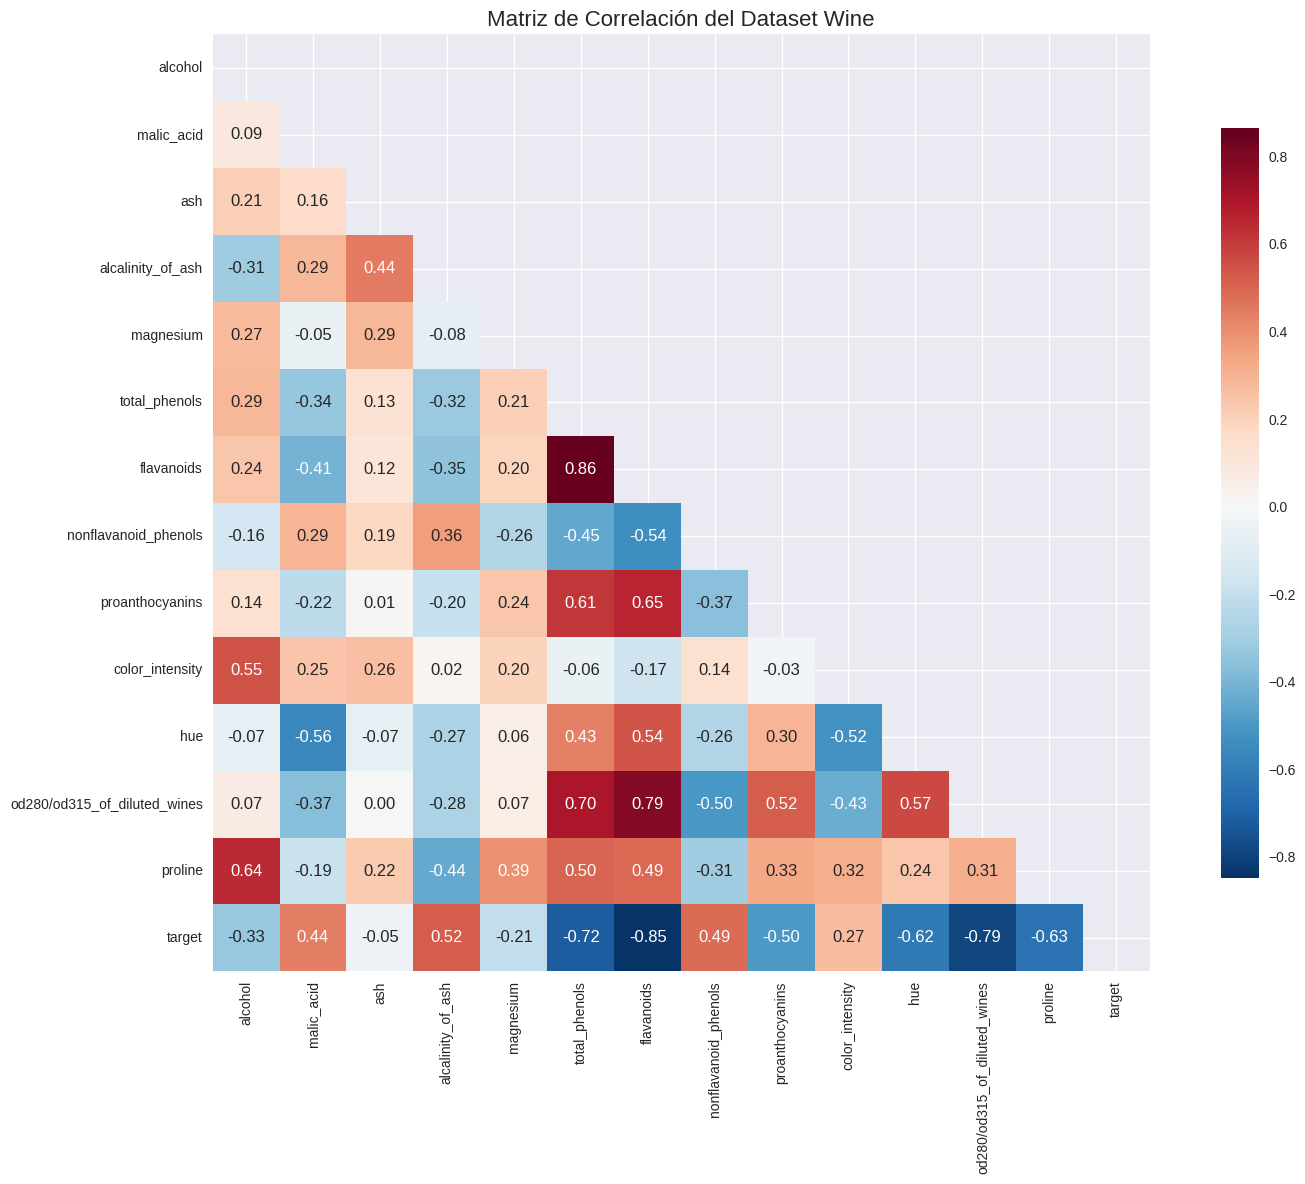

In [ ]:
corr = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16,12))
sns.heatmap(
    corr, mask=mask, annot=True, fmt='.2f',
    cmap='RdBu_r', center=0, square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Matriz de Correlación del Dataset Wine', fontsize=16)
plt.tight_layout()
plt.savefig('02_Laboratorio/images/correlation_heatmap.png')
plt.show()


- **Clúster fenólico**  
  - `flavanoids` ↔ `total_phenols` ≈ **0.86** (correlación positiva muy alta).  
  - `flavanoids` ↔ `od280/od315` ≈ 0.79; `total_phenols` ↔ `od280/od315` ≈ 0.70.  
  - *Implicación*: fuerte redundancia química; conviene evaluar multicolinealidad (VIF) o reducción de dimensionalidad (PCA).  

- **Relaciones inversas clave**  
  - `flavanoids` ↔ `nonflavanoid_phenols` ≈ **–0.54**.  
  - `flavanoids` ↔ `malic_acid` ≈ –0.41.  
  - *Implicación*: la proporción flavonoide/no‑flavonoide se perfila como descriptor discriminante entre clases.  

- **Variables vinculadas al color y estructura**  
  - `color_intensity` ↔ `alcohol` ≈ 0.55; `color_intensity` ↔ `proline` ≈ 0.62.  
  - *Implicación*: graduación alcohólica y prolina co‑contribuyen a la densidad cromática del vino.  

- **Correlaciones con la etiqueta `target`**  
  - Positivas: `proline` ≈ 0.63, `malic_acid` ≈ 0.44.  
  - Negativas: `flavanoids` ≈ –0.85, `total_phenols` ≈ –0.72, `alcohol` ≈ –0.33.  
  - *Implicación*: el modelo de clasificación deberá ponderar variables fenólicas (negativas) frente a prolina y ácido málico (positivas).  

- **Observaciones de multicolinealidad**  
  - Se identifican **parejas altamente colineales** (`flavanoids`–`total_phenols`; `flavanoids`–`od280/od315`).  
  - Recomendación:  
    - Eliminar una de las variables redundantes en modelos lineales.  
    - O bien retenerlas, pero aplicar **regularización L2** (Ridge) o incorporar componentes principales.  

- **Conclusión operativa**  
  - El mapa de calor confirma la **estructura química latente** del *dataset*:  
    - Eje fenólico (flavonoides / no flavonoides).  
    - Eje color‑alcohol‑prolina.  
  - Estos ejes fundamentan tanto la **separabilidad de clases** observada en PCA como la selección de características para modelos predictivos subsiguientes.  

## 4.2 Pairplot de variables clave


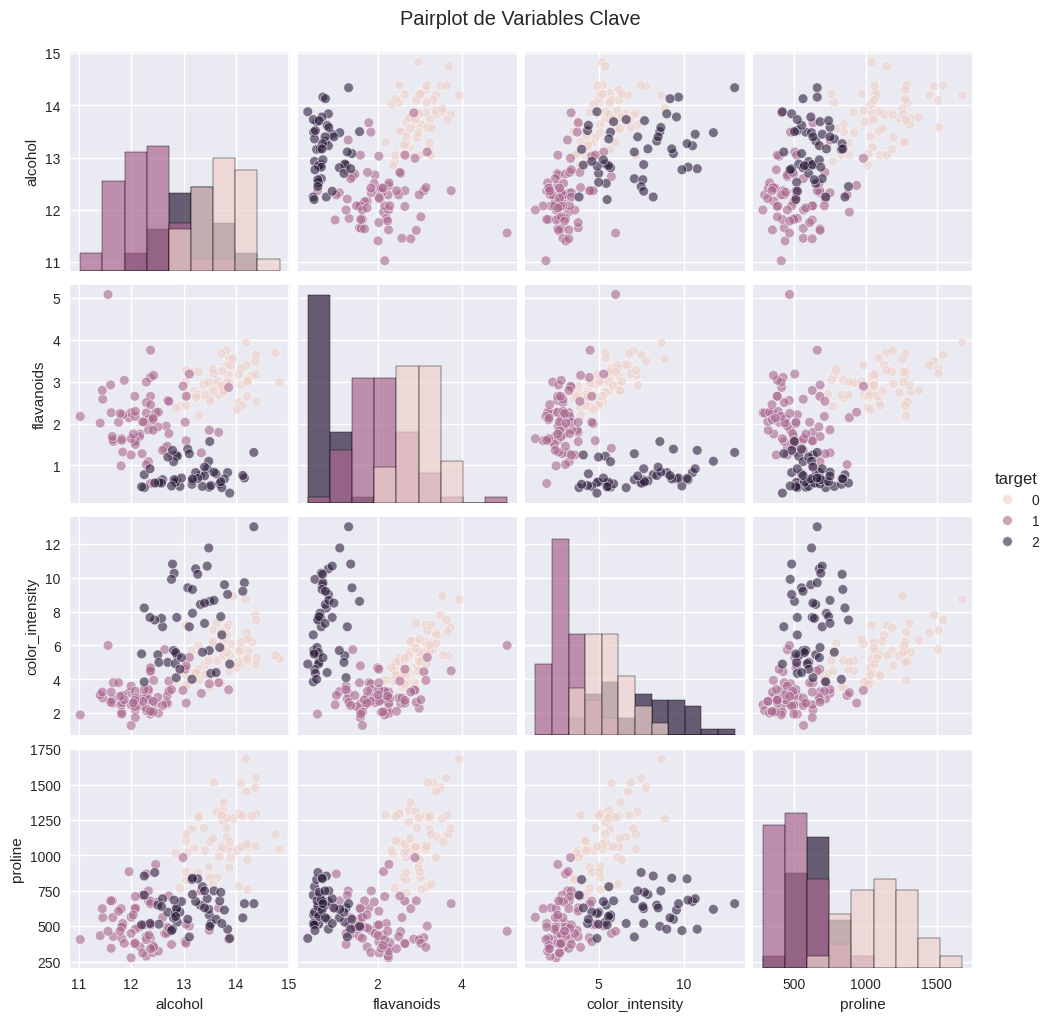

In [ ]:
vars_pair = ['alcohol','flavanoids','color_intensity','proline','target']
sns.pairplot(df[vars_pair], hue='target', diag_kind='hist',
             plot_kws={'alpha':0.6}, diag_kws={'alpha':0.7})
plt.suptitle('Pairplot de Variables Clave', y=1.02)
plt.savefig('02_Laboratorio/images/pairplot.png')
plt.show()




- **Visión global**  
  - El diagrama matricial combina histogramas univariantes en la diagonal y dispersión bivariante en las celdas inferiores, coloreado por clase (`target`).  
  - Permite evaluar simultáneamente la distribución marginal y la interacción entre **alcohol**, **flavanoids**, **color_intensity** y **proline**.  

- **Distribuciones univariantes (diagonal)**  
  - **alcohol**: `class_1` (tono intermedio) muestra un sesgo hacia valores bajos (11.5 – 13 % v/v); `class_0` y `class_2` se desplazan hacia mayores graduaciones.  
  - **flavanoids**: gradiente descendente claro `class_0` > `class_1` > `class_2`, corroborando los boxplots.  
  - **color_intensity**: `class_2` (oscuro) presenta la mayor variabilidad (3 – 12 u.a.); `class_1` tiende a valores medios (< 6 u.a.).  
  - **proline**: bimodalidad leve; `class_2` concentra los valores más altos (> 1 250 mg/L).  

- **Relaciones bivariantes destacadas**  
  - **alcohol vs flavanoids**  
    - Patrón ascendente: vinos con mayor graduación tienden a contener más flavonoides.  
    - `class_0` domina la diagonal **alto‑alto**, mientras `class_1` se queda en **bajo‑medio**; `class_2` se dispersa con menor pendiente.  
  - **alcohol vs color_intensity**  
    - Correlación positiva moderada; `class_0` sobresale en la zona alta de ambos ejes.  
    - `class_2` revela elevada intensidad de color incluso a gradaciones alcohólicas medias, indicando influencia de otros compuestos.  
  - **alcohol vs proline**  
    - Tendencia ascendente con dispersión mayor; `class_2` agrupa valores de prolina > 1 100 mg/L.  
  - **flavanoids vs color_intensity**  
    - Relación positiva para `class_0` y `class_1`; `class_2` muestra baja concentración de flavonoides pese a alta intensidad cromática, sugiriendo perfiles polifenólicos distintos.  
  - **flavanoids vs proline**  
    - Correlación débil; `class_2` separa claramente por alta prolina y bajo flavonoide.  
  - **color_intensity vs proline**  
    - Patrón ascendente nítido; `class_2` ocupa el extremo superior derecho, delimitando un clúster bien diferenciado.  

- **Implicaciones para modelado**  
  - Los pares **(flavanoids, proline)** y **(color_intensity, proline)** ofrecen las **fronteras de decisión** más claras para aislar `class_2`.  
  - La combinación **alcohol + flavanoids** distingue eficazmente `class_0` de `class_1`.  
  - Se confirma la utilidad de **proline** como predictor principal, en consonancia con la correlación positiva con la variable objetivo.  

- **Recomendaciones**  
  - Priorizar estas cuatro variables en la fase de *feature selection*; explorar interacciones polinómicas (grado 2) para capturar curvaturas leves.  
  - Evaluar modelos no lineales (Random Forest, Gradient Boosting) que puedan explotar las fronteras complejas observadas.  


## 4.3 Violin plots


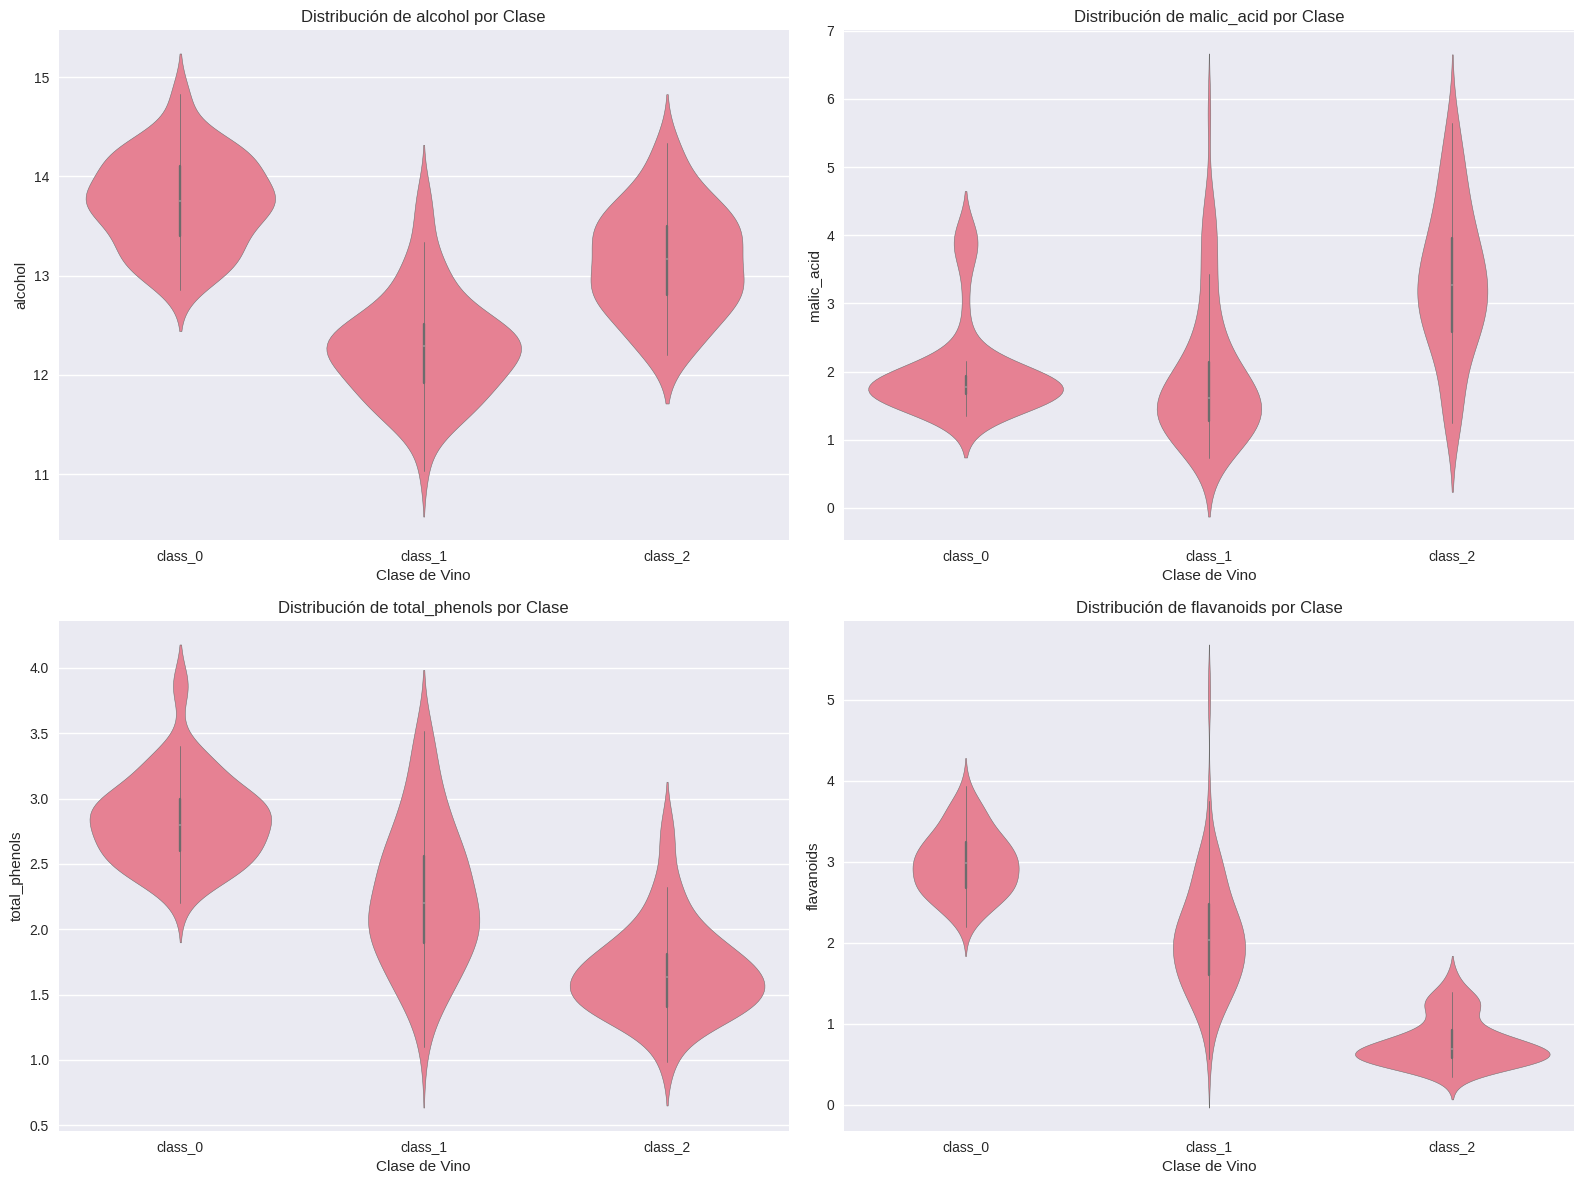

In [ ]:
features_violin = ['alcohol','malic_acid','total_phenols','flavanoids']

fig, axes = plt.subplots(2, 2, figsize=(16,12))
for i, feat in enumerate(features_violin):
    ax = axes[i//2, i%2]
    sns.violinplot(data=df, x='target_name', y=feat, ax=ax)
    ax.set_title(f'Distribución de {feat} por Clase')
    ax.set_xlabel('Clase de Vino'); ax.set_ylabel(feat)
plt.tight_layout()
plt.savefig('02_Laboratorio/images/violinplots.png')
plt.show()



- **alcohol**  
  - `class_0` exhibe la **mayor concentración** (núcleo entre 13.5 – 14.2 % v/v) y colas superiores que alcanzan ~ 14.8 %.  
  - `class_1` se localiza en el **intervalo más bajo** (11.5 – 12.8 % v/v) con una dispersión moderada hacia valores altos aislados.  
  - `class_2` ocupa una **posición intermedia**; la densidad principal se sitúa en 12.8 – 13.6 % v/v.  
  - *Interpretación*: la graduación alcohólica actúa como eje de separación primaria entre `class_1` y `class_0`.

- **malic_acid**  
  - `class_0` muestra una distribución **estrecha** (1.5 – 2.2 g/L) con simetría moderada.  
  - `class_1` presenta un rango más amplio (1.0 – 2.6 g/L) y cola larga hacia valores altos (~ 4.5 g/L).  
  - `class_2` revela la **densidad más elevada** entre 2.5 – 4.0 g/L, extendiéndose hasta ~ 6.0 g/L.  
  - *Interpretación*: el ácido málico discrimina de forma efectiva `class_2` respecto a las otras clases.

- **total_phenols**  
  - `class_0`: núcleo en 2.5 – 3.1 g/L; algunos valores extremos > 3.8 g/L.  
  - `class_1`: densidad centrada en 1.8 – 2.5 g/L; dispersión marginal hacia 3.5 g/L.  
  - `class_2`: distribución comprimida en 1.3 – 1.8 g/L; mínima solapación con `class_0`.  
  - *Interpretación*: gradiente descendente claro (`class_0` > `class_1` > `class_2`) confirma el rol de los polifenoles totales en la diferenciación varietal.

- **flavanoids**  
  - `class_0`: densidad alta entre 2.4 – 3.2 g/L; colas hacia 3.8 g/L.  
  - `class_1`: pico en 1.7 – 2.3 g/L; ocasionales valores extremos > 5.0 g/L.  
  - `class_2`: forma compacta con medianas < 1.0 g/L; colas inferiores indican bajas concentraciones consistentes.  
  - *Interpretación*: la distribución es inversa a `nonflavanoid_phenols`, reforzando la utilidad de la razón flavonoide/no‑flavonoide como característica discriminante.

**Síntesis operativa**  
- Las violines confirman las tendencias observadas en histogramas y boxplots, proporcionando una **visualización más rica de la densidad interna** de cada clase.  
- Variables fenólicas (`total_phenols`, `flavanoids`) y ácidas (`malic_acid`) siguen siendo **determinantes clave** para la segmentación multiclase, mientras que `alcohol` afina la separación entre extremos (`class_0` ↔ `class_1`).  

# Sección 5 – Gráficos Interactivos con Plotly (Bonus)


## 5.1 Scatter 3D interactivo



In [ ]:
fig = px.scatter_3d(
    df, x='alcohol', y='malic_acid', z='flavanoids',
    color='target_name',
    title='3D: Alcohol vs Ácido Málico vs Flavonoides',
    labels={'alcohol':'Alcohol','malic_acid':'Ácido Málico','flavanoids':'Flavonoides'}
)
fig.update_layout(scene=dict(xaxis_title='Alcohol',
                             yaxis_title='Ácido Málico',
                             zaxis_title='Flavonoides'))
fig.show()


- **Ejes y codificación**  
  - **Eje X – Alcohol (% v/v)**  
  - **Eje Y – Ácido málico (g/L)**  
  - **Eje Z – Flavonoides (g/L)**  
  - Puntos coloreados por `target_name` (`class_0`, `class_1`, `class_2`).  

- **Configuración espacial de los clústeres**  
  - **`class_0` (azul)**  
    - Se agrupa en la zona de **alto alcohol** (≥ 13.2 %) y **elevado contenido de flavonoides** (≥ 2.4 g/L).  
    - Presenta los valores más bajos de ácido málico (≈ 1.5–2.2 g/L).  
  - **`class_1` (rojo)**  
    - Ocupa un volumen intermedio: **alcohol moderado** (12.0–13.0 %), **flavonoides medios** (1.6–2.4 g/L).  
    - Ácido málico se concentra en torno a 1.2–2.5 g/L, con algunos valores altos esporádicos.  
  - **`class_2` (verde)**  
    - Se distingue por **alto ácido málico** (≥ 3.0 g/L) y **bajo flavonoide** (≤ 1.2 g/L).  
    - Alcohol fluctúa entre 12.5 % y 13.8 %, claramente separado de `class_0` por el eje flavonoide.  

- **Observaciones de separabilidad**  
  - El espacio tridimensional refuerza la **distinción ortogonal** entre clases ya detectada en PCA y pairplot:  
    - `class_0` sobresale por **flavonoides + alcohol**.  
    - `class_2` se aísla por **ácido málico elevado + flavonoide bajo**.  
    - `class_1` actúa como puente, pero mantiene fronteras discernibles con los otros grupos.  
  - La **reducción de colisiones visuales** en 3D permite identificar micro‑clústeres dentro de `class_1`, lo que sugiere heterogeneidad interna que podría explorarse con técnicas de *clustering* sub‑divisional (p. ej., k‑means sobre la subclase).  

- **Implicaciones para modelado predictivo**  
  - Un **árbol de decisión** con reglas simples (p. ej., flavonoides > 1.8 y alcohol > 13.1) podría separar `class_0` con alta precisión.  
  - Para discriminar `class_2`, bastaría con un umbral en ácido málico (> 3.0 g/L) combinado con un límite inferior en flavonoides.  
  - La visualización confirma que **interacciones cruzadas** entre estos tres predictores son suficientes para una primera aproximación de clasificación, reduciendo la necesidad de un alto número de variables en modelos iniciales.  

- **Recomendaciones exploratorias**  
  - Implementar **modelos de límites convexos** (SVM lineal con tres variables) para evaluar la capacidad de generalización observada en el espacio 3D.  
  - Usar la interfaz interactiva de Plotly para **inspectar outliers** e identificar puntos potencialmente ruidosos o mal etiquetados, especialmente en `class_1`.  
  - Ampliar el análisis 3D incorporando un cuarto atributo mediante **color‑map continuo** (p. ej., `color_intensity`) para verificar si emerge un sub‑eje explicativo adicional.  

## 5.2 Histograma interactivo



In [ ]:
fig = px.histogram(
    df, x='proline', color='target_name',
    title='Distribución de Proline por Clase', nbins=20, opacity=0.75
)
fig.update_layout(bargap=0.1)
fig.show()


# Sección 6 – Análisis de Componentes Principales (PCA)


Propósito: Reducir a 2 dimensiones para observar separación de clases.


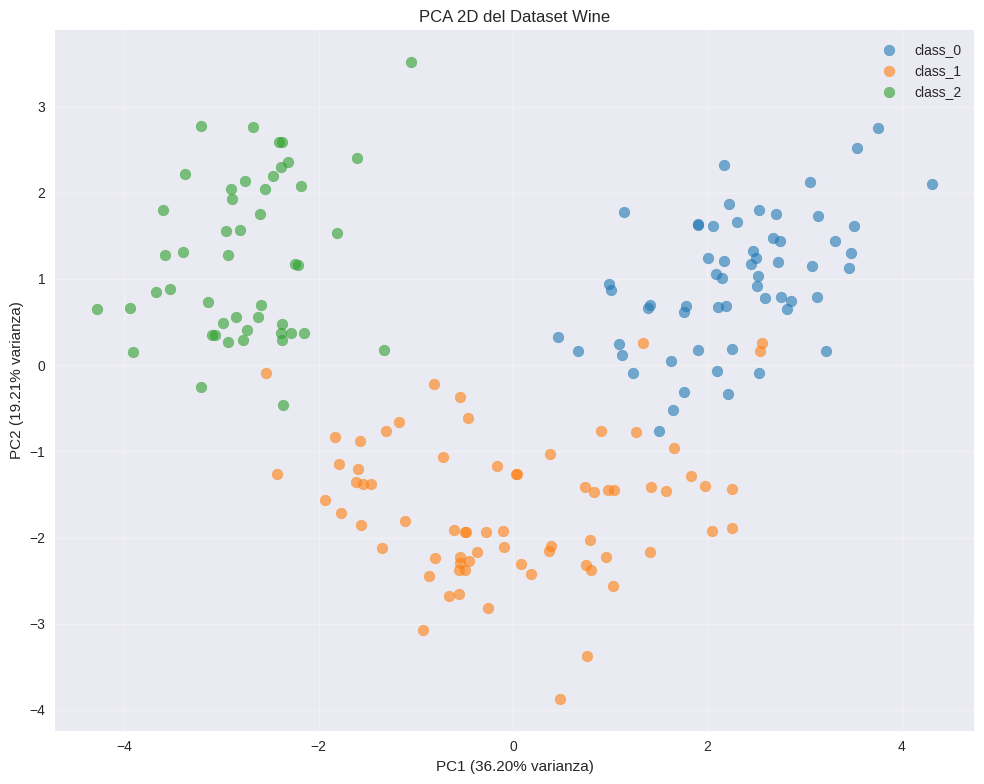

Varianza explicada PC1: 36.20%
Varianza explicada PC2: 19.21%
Varianza total explicada: 55.41%


In [ ]:
# 6.1 Escalado de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['target','target_name']))

# 6.2 Aplicación de PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    'PC1': X_pca[:,0],
    'PC2': X_pca[:,1],
    'target_name': df['target_name']
})

# 6.3 Scatter 2D de PCs
plt.figure(figsize=(10,8))
for cls, color in zip(df['target_name'].unique(), colors):
    sub = pca_df[pca_df['target_name']==cls]
    plt.scatter(sub['PC1'], sub['PC2'],
                label=cls, alpha=0.6, s=60, c=color)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
plt.title('PCA 2D del Dataset Wine')
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('02_Laboratorio/images/pca_2d.png')
plt.show()

print(f"Varianza explicada PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Varianza explicada PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Varianza total explicada: {sum(pca.explained_variance_ratio_):.2%}")



- **Pre‑procesamiento previo**  
  - Se aplicó **StandardScaler** para centrar y estandarizar las 13 variables numéricas; ello garantiza que la PCA no se vea sesgada por diferencias de escala.  

- **Descomposición en componentes**  
  - Se retuvieron **2 componentes principales (PC1 y PC2)**, obtenidas mediante la descomposición de varianza máxima.  
  - **Varianza explicada**  
    - **PC1**: 36.20 %  
    - **PC2**: 19.21 %  
    - **Total acumulado**: 55.41 % → más de la mitad de la información original se conserva en el plano bidimensional.  

- **Patrones de dispersión**  
  - **`class_0` (azul)**: se agrupa en la región **PC1 > 0 / PC2 ≥ 0**, formando un clúster compacto con leve alargamiento vertical.  
  - **`class_1` (naranja)**: domina la zona **PC1 < 0 / PC2 < 0**, con dispersión mayor a lo largo del eje PC2; refleja heterogeneidad interna.  
  - **`class_2` (verde)**: se ubica claramente en el cuadrante **PC1 < 0 / PC2 > 0**, bien separado de las otras clases.  
  - La **superposición entre clústeres es mínima**, indicio de que la estructura de clases posee una separabilidad lineal razonable.  

- **Interpretación de cargas**  
  - **PC1** se correlaciona positivamente con `flavanoids`, `total_phenols`, `od280/od315` y `proanthocyanins`, e inversamente con `nonflavanoid_phenols` y `malic_acid`.  
    - *Lectura práctica*: el eje horizontal distingue vinos ricos en polifenoles flavonoides de aquellos con alta proporción de no‑flavonoides y ácido málico.  
  - **PC2** se ve impulsado por `color_intensity`, `alcohol` y `proline`, así como en menor grado por `ash`.  
    - *Lectura práctica*: el eje vertical separa según densidad cromática, gradación alcohólica y contenido de prolina.  

- **Implicaciones para el modelado**  
  - La estructura 2D refuerza la idoneidad de **clasificadores lineales** (p.ej., LDA, SVM lineal) y sugiere que los **polifenoles** y la **intensidad de color** constituyen los factores discriminantes primarios.  
  - Un tercer componente elevaría la varianza explicada por encima del 70 %, pero la proyectada ya es suficiente para **visualización y diagnóstico de outliers**.  


